Created: 2020.08.13

Modified: 2020.08.28

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.core import parallel

import time
import random
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.color import gray2rgb

In [3]:
import sys
sys.path.append('functions')

%aimport functions00, functions01
from functions00 import *
from functions01 import *

import functions32 as f32
import functions50 as f50

In [4]:
mk_get_host_info()

**********************************************************************************************************************************
Settings:
	HOST:  mmiv-ml-titan
	PATH_ROOT_DATA:  /data-10tb/shared/skull/train-3d-iso
	PATH_GIT_HUB:  /data-10tb/marek/github_codes/skull-stripping-1/fastai
	PATH_2D: /data-10tb/shared/skull

3D NIFTI image DF paths (_mk_3D):
	IXI_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/ixi_test_mk_3d.csv
	TEST_3D : /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/test_mk_3d.csv
	TRAIN_VAL_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/train_val_mk_3d.csv
	NFBS_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/nfbs_test_mk_3d.csv

Error files (pickle):
	ERROR_FILES: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/error_files
***********************************************************


# 2D AXIAL - T1 biascorr

Test set:
1. TEST_3D
1. IXI_TEST_3D
___

#### Some global variables

In [5]:
TEST_SET_NAME = 'TEST_3D'
SAVE_PTH_301_DATA = PATH_2D / 'pred' / '3.01' / TEST_SET_NAME
SAVE_PTH_301_CSV = PATH_GIT_HUB / '5.0'

In [6]:
mk_wrap_text(TEST_SET_NAME)

*****************
*** TEST_3D   ***
*****************


### Load df for training; get a few of the train rows

In [7]:
# LOADING TRAIN_VAL CSV FILE, REMOVE VAL PART AND MOST OF THE TRAIN PART
folder_path = PATH_2D /'axial-2d'

# csv file with path to images and masks
DATA_PATH_CSV_2D = 'bias_mask-test-val-axial-2d.csv'

df1 = pd.read_csv(folder_path/DATA_PATH_CSV_2D)
df1 = df1[df1['usage_txt'] == 'train'][:128*3]

# print(df1.shape)
print(df1.shape)
#df_train.head(1)

(384, 6)


In [8]:
# LOAD TEST_3D_CSV
test_name = PATH_2D /'axial-2d' / f'{TEST_SET_NAME}-bias-mask-axial-2d.csv'
df2 = pd.read_csv(test_name, index_col=None)
print(df2.shape)
#df_test.head(2)

(157036, 6)


In [9]:
# CONCATENATE TRAIN ADN TEST TABLES
df_test = pd.concat([df1, df2])
print(df_test.shape)
df_test.tail(2)

(157420, 6)


,root,bias_path,image_full_path,mask_full_path,usage_txt,usage
157034,/data-10tb/shared/skull/axial-2d/,/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_164.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_164.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_brain_mask_iso_n...,test_3d,True
157035,/data-10tb/shared/skull/axial-2d/,/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_165.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_iso_165.png,/data-10tb/shared/skull/axial-2d/test/SLIM/sub-31055_ses-3_T1w.anat/T1_biascorr_brain_mask_iso_n...,test_3d,True


In [10]:
if 'titan' in HOST:
    #df_files_exists(df, ['t1_pth_titan', 'bias_pth_titan', 'mask_nn_pth_titan', 'mask_lin_pth_titan'])
    mk_df_files_exists(df_test, ['image_full_path', 'mask_full_path'])

Looing for NOT EXISTING files in "df.image_full_path"
	All files are OK

Looing for NOT EXISTING files in "df.mask_full_path"
	All files are OK



## Create DataBunch

In [11]:
# item list
il = SegmentationItemList.from_df(df_test, folder_path, cols='bias_path', convert_mode='L')

In [12]:
# split data
sd = il.split_from_df(col='usage')

In [13]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [14]:
# label list
ll = sd.label_from_df(cols='mask_full_path', classes=codes)

In [15]:
tmfs2 = get_transforms(do_flip=True, flip_vert=False,
                      max_rotate=15, max_zoom=1.05,
                      max_lighting=0.2, max_warp=None,
                      p_affine=0.5, p_lighting=0.5
                      )
bs=128
size = 128

In [16]:
ll = ll.transform(tmfs2, tfm_y=True, size=size, padding_mode='zeros', resize_method=ResizeMethod.PAD)

In [17]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [18]:
data.train_ds[0]

(Image (1, 128, 128), ImageSegment (1, 128, 128))

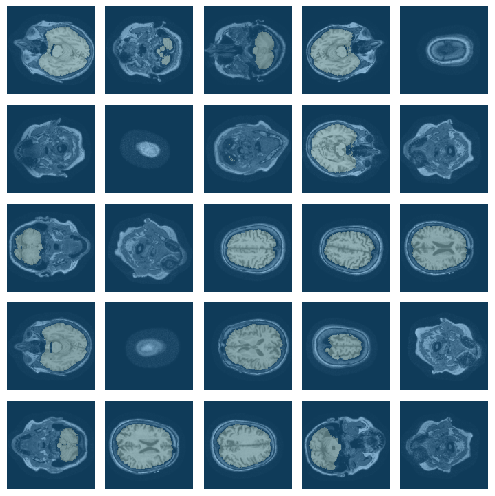

In [19]:
data.show_batch(5, figsize=(7,7))

In [20]:
# load a model
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)
learn.load('3.01_02_train-axial_bias_uf_foc-20_lr-1e3_sp-all');

In [21]:
learn.export()

____

### Measure prediction time

In [22]:
names =  learn.data.valid_dl.dataset.items

In [23]:
names[:3]

array(['/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_S9136_I32246.anat/T1_biascorr_iso_000.png',
       '/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_S9136_I32246.anat/T1_biascorr_iso_001.png',
       '/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_S9136_I32246.anat/T1_biascorr_iso_002.png'],
      dtype='<U173')

In [24]:
defaults.device = torch.device('cpu')

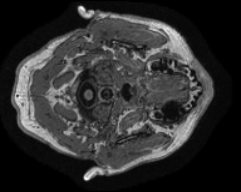

In [25]:
img = open_image(names[0])
img

In [26]:
learn = load_learner('/data-10tb/shared/skull/axial-2d/')

In [27]:
print(len(names))

157036


In [29]:
exams = sorted(list(set([n.split('/')[-2] for n in names])))
df_n = pd.DataFrame.from_dict({'names':names})

ex = exams[0]
df_ex = df_n[df_n.names.str.contains(ex)]
df_ex.head(3)

,names
22100,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3_...
22101,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3_...
22102,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3_...


In [30]:
exams[:3]

['ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001114742166_S13893_I118673.anat',
 'ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001120813046_S22557_I118695.anat',
 'ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070713121420365_S32938_I60008.anat']

In [31]:
av = []

k = 0
l = len(exams)
for i, ex in enumerate(exams):
    df_ex = df_n[df_n.names.str.contains(ex)]

    start = time.time()
    for i in df_ex.names:
        img = open_image(i)
        pred_class,pred_idx,outputs = learn.predict(img)
    end = time.time()
    
    av.append(end - start)
    print(f'{k}/{l}', end='\r')
    k +=1 

In [32]:
av=np.array(av)
print(mk_wrap_text(TEST_SET_NAME))
print(f'Mean time: {av.mean().round(4)}')
print(f'Std. : {av.std().round(4)}')

npy_save_name = f'/data-10tb/shared/skull/pred/3.01/{TEST_SET_NAME}/3.01_{TEST_SET_NAME}_prediction_time.npy'
np.save(npy_save_name, av)

*****************
*** TEST_3D   ***
*****************
None
Mean time: 12.3645
Std. : 0.5683
